**Bibliotheken**

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from factor_analyzer import FactorAnalyzer
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import f_oneway

**Datenmenge wird geladen**

In [2]:

#Datei einlesen (Pfad anpassen, wenn nötig)
df = pd.read_excel('/Users/umerhanif/Desktop/Vortrag/datenmenge2.0.xlsx')

#Ersten Blick auf die Daten
df.head()

,Identifier (RIC),Company Name,"EBIT - Actual\n(FY0, USD)","EBITDA - Actual\n(FY0, USD)",Return On Capital Employed - Actual\n(FY0),"Total Assets - Actual\n(FY0, USD)","Net Debt - Actual\n(FY0, USD)",Cash Ratio\n(FY0),"Shareholders Equity - Actual\n(FY0, USD)",Current Ratio\n(FY0),Return On Equity - Actual\n(FY0),Revenue (LTM)
0,ADBE.OQ,Adobe Inc,10019000000,10542000000,0.50829,30230000000,-2258000000,0.72360,14105000000,1.06758,0.54080,22037000000
1,GOOGL.OQ,Alphabet Inc,112390000000,150486000000,0.31120,450256000000,-84774000000,0.26330,325084000000,1.83693,0.32909,359713000000
2,AMZN.TO,Amazon.com Inc,68593000000,144162000000,0.15400,624894000000,-48579000000,0.56000,285970000000,1.05000,0.24289,694994349380
3,AAPL.TO,Apple Inc,123216000000,134661000000,0.65340,364980000000,42354000000,0.37000,56950000000,0.82000,1.74620,400366000000
4,ASAN.N,Asana Inc,-40787000,-23244000,-0.34299,891415000,-422294000,0.44425,227523000,1.44472,-0.10679,723876000


**Überblick über fehlende Werte**



In [3]:
df.isna().mean().sort_values(ascending=False)

Identifier (RIC)                              0.0
Company Name                                  0.0
EBIT - Actual\n(FY0, USD)                     0.0
EBITDA - Actual\n(FY0, USD)                   0.0
Return On Capital Employed - Actual\n(FY0)    0.0
Total Assets - Actual\n(FY0, USD)             0.0
Net Debt - Actual\n(FY0, USD)                 0.0
Cash Ratio\n(FY0)                             0.0
Shareholders Equity - Actual\n(FY0, USD)      0.0
Current Ratio\n(FY0)                          0.0
Return On Equity - Actual\n(FY0)              0.0
Revenue (LTM)                                 0.0
dtype: float64

**Bennenung der Kennzahlen**

Spaltennamen werden umbenannt, um sie einheitlich und verständlich für die spätere Analyse zu machen.

In [4]:
df.rename(columns={
    'EBIT - Actual\n(FY0, USD)': 'EBIT',
    'EBITDA - Actual\n(FY0, USD)': 'EBITDA',
    'Return On Capital Employed - Actual\n(FY0)': 'ROCE',
    'Total Assets - Actual\n(FY0, USD)': 'TotalAssets',
    'Net Debt - Actual\n(FY0, USD)': 'NetDebt',
    'Cash Ratio\n(FY0)': 'CashRatio',
    'Shareholders Equity - Actual\n(FY0, USD)': 'Equity',
    'Current Ratio\n(FY0)': 'CurrentRatio',
    'Return On Equity - Actual\n(FY0)': 'ROE',
    'Revenue – Mean\n(FY1, USD)': 'Revenue',

}, inplace=True)


**Irrelevante Spalten entfernen**



In [5]:
df_clean = df.drop(columns=["Identifier (RIC)"])
df_clean.head()

,Company Name,EBIT,EBITDA,ROCE,TotalAssets,NetDebt,CashRatio,Equity,CurrentRatio,ROE,Revenue (LTM)
0,Adobe Inc,10019000000,10542000000,0.50829,30230000000,-2258000000,0.72360,14105000000,1.06758,0.54080,22037000000
1,Alphabet Inc,112390000000,150486000000,0.31120,450256000000,-84774000000,0.26330,325084000000,1.83693,0.32909,359713000000
2,Amazon.com Inc,68593000000,144162000000,0.15400,624894000000,-48579000000,0.56000,285970000000,1.05000,0.24289,694994349380
3,Apple Inc,123216000000,134661000000,0.65340,364980000000,42354000000,0.37000,56950000000,0.82000,1.74620,400366000000
4,Asana Inc,-40787000,-23244000,-0.34299,891415000,-422294000,0.44425,227523000,1.44472,-0.10679,723876000


In [6]:
#EBIT-Marge
df_clean["EBIT_Marge"] = df_clean["EBIT"] / df_clean["Revenue (LTM)"]

#EBITDA-Marge
df_clean["EBITDA_Marge"] = df_clean["EBITDA"] / df_clean["Revenue (LTM)"]

#NetDebt / EBITDA
df_clean["NetDebt_EBITDA"] = df_clean["NetDebt"] / df_clean["EBITDA"]

#Eigenkapitalquote
df_clean["Eigenkapitalquote"] = df_clean["Equity"] / df_clean["TotalAssets"]


final_columns = [
    "Company Name",
    "ROE",
    "EBIT_Marge",
    "EBITDA_Marge",
    "ROCE",
    "Eigenkapitalquote",
    "NetDebt_EBITDA",
    "CashRatio",
    "CurrentRatio"
]

df_final = df_clean[final_columns].copy()



In [7]:
df_final.head()

,Company Name,ROE,EBIT_Marge,EBITDA_Marge,ROCE,Eigenkapitalquote,NetDebt_EBITDA,CashRatio,CurrentRatio
0,Adobe Inc,0.54080,0.454644,0.478377,0.50829,0.466589,-0.214191,0.72360,1.06758
1,Alphabet Inc,0.32909,0.312444,0.418350,0.31120,0.721998,-0.563335,0.26330,1.83693
2,Amazon.com Inc,0.24289,0.098696,0.207429,0.15400,0.457630,-0.336975,0.56000,1.05000
3,Apple Inc,1.74620,0.307758,0.336345,0.65340,0.156036,0.314523,0.37000,0.82000
4,Asana Inc,-0.10679,-0.056345,-0.032110,-0.34299,0.255238,18.167871,0.44425,1.44472


In [8]:

#Daten extrahieren und skalieren
X = df_final.drop(columns=["Company Name"])
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

#In DataFrame mit Spaltennamen umwandeln
X_std = pd.DataFrame(X_std, columns=X.columns)


**Korellationsmatrix**

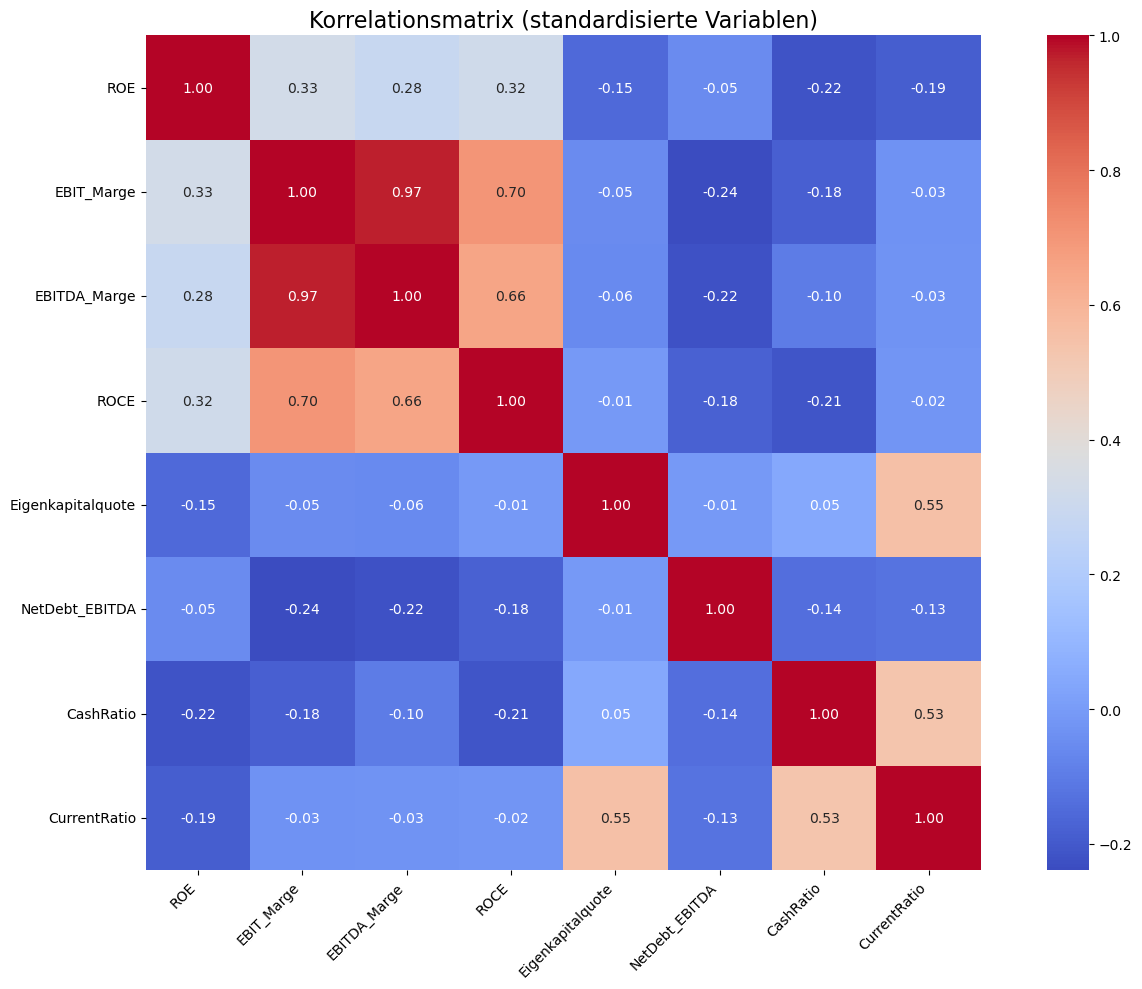

In [9]:


#Korrelationsmatrix auf Basis der standardisierten Daten X_std berechnen
correlation_matrix_std = X_std.corr()

#Heatmap darstellen
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_std, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar=True)
plt.title("Korrelationsmatrix (standardisierte Variablen)", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


**KMO & Barlett Test**

In [10]:


#KMO-Test
kmo_all, kmo_model = calculate_kmo(X_std)
print("KMO-Gesamtwert:", round(kmo_model, 3))

#Bartlett-Test
chi_square_value, p_value = calculate_bartlett_sphericity(X_std)
print("Bartlett Chi²:", round(chi_square_value, 2), "| p-Wert:", p_value)

#Optional: individuelle KMO-Werte nach Variable
#pd.Series(kmo_all, index=X.columns).sort_values()

KMO-Gesamtwert: 0.559
Bartlett Chi²: 197.93 | p-Wert: 1.6912452969328593e-27


**Individuelle KMO-Werte der Variablen**

In [11]:

# Individuelle KMO-Werte anzeigen und sortieren
pd.Series(kmo_all, index=X.columns).sort_values()


CashRatio            0.337656
Eigenkapitalquote    0.371333
CurrentRatio         0.417368
EBIT_Marge           0.569216
EBITDA_Marge         0.569238
NetDebt_EBITDA       0.751207
ROE                  0.867511
ROCE                 0.921468
dtype: float64

**Scree-Plot**

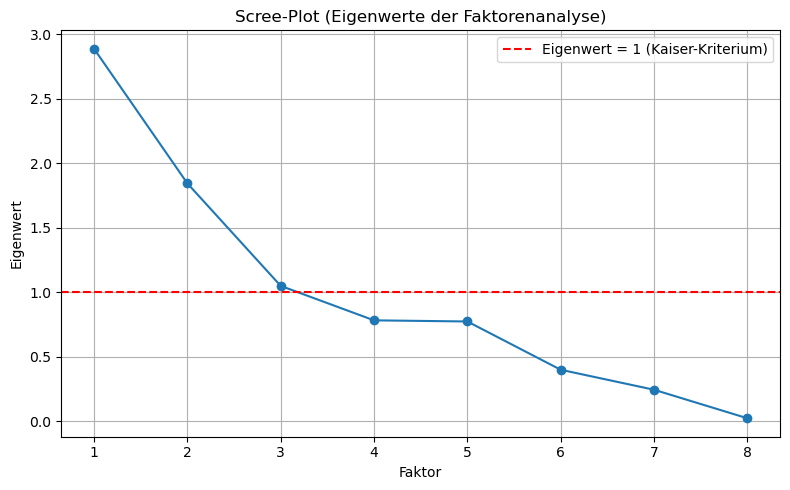

In [12]:


#FA-Modell vorbereiten
fa = FactorAnalyzer(n_factors=X_std.shape[1], rotation=None)
fa.fit(X_std)

#Eigenwerte extrahieren
ev, v = fa.get_eigenvalues()

#Scree-Plot zeichnen
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(ev) + 1), ev, marker='o')
plt.axhline(y=1, color='red', linestyle='--', label='Eigenwert = 1 (Kaiser-Kriterium)')
plt.title("Scree-Plot (Eigenwerte der Faktorenanalyse)")
plt.xlabel("Faktor")
plt.ylabel("Eigenwert")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


**Interpretation des Scree-Plot**

In [13]:

eigen_df = pd.DataFrame({"Faktor": range(1, len(ev)+1), "Eigenwert": ev})
eigen_df.round(2)



,Faktor,Eigenwert
0,1,2.89
1,2,1.84
2,3,1.05
3,4,0.78
4,5,0.77
5,6,0.40
6,7,0.24
7,8,0.02


**Eigenvektoren**

In [14]:

#Korrelationsmatrix berechnen
corr_matrix = np.corrcoef(X_std.T)

#Eigenwerte und Eigenvektoren berechnen
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

#Eigenvektoren als DataFrame darstellen
eigvecs_df = pd.DataFrame(
    eigenvectors,
    columns=[f"Faktor {i+1}" for i in range(eigenvectors.shape[1])],
    index=X_std.columns
)

#Eigenvektoren anzeigen
print("Eigenvektoren:")
display(eigvecs_df.round(3))


Eigenvektoren:


,Faktor 1,Faktor 2,Faktor 3,Faktor 4,Faktor 5,Faktor 6,Faktor 7,Faktor 8
ROE,0.307,0.170,0.023,0.023,0.104,-0.034,0.807,0.462
EBIT_Marge,0.550,-0.147,-0.727,-0.088,0.305,-0.017,-0.079,-0.201
EBITDA_Marge,0.530,-0.169,0.676,0.045,0.383,0.023,-0.074,-0.280
ROCE,0.480,-0.114,0.037,0.157,-0.842,-0.130,-0.025,-0.063
Eigenkapitalquote,-0.100,-0.462,-0.028,0.483,0.173,-0.635,-0.106,0.313
NetDebt_EBITDA,-0.163,0.275,-0.021,0.005,-0.003,-0.561,0.366,-0.670
CashRatio,-0.198,-0.445,-0.090,0.498,-0.027,0.500,0.376,-0.340
CurrentRatio,-0.128,-0.649,0.061,-0.696,-0.100,-0.115,0.225,-0.023


**Faktorladung & Kommunalität**

In [15]:


#Faktor-Analyse mit 3 Faktoren und Varimax-Rotation
fa = FactorAnalyzer(n_factors=3, rotation='varimax')
fa.fit(X_std)

#Ladungsmatrix (wie stark lädt jede Variable auf jeden Faktor)
loadings = pd.DataFrame(fa.loadings_, index=X.columns, columns=["Faktor 1", "Faktor 2", "Faktor 3"])

#Kommunalitäten (wie gut wird jede Variable durch die Faktoren erklärt)
communalities = pd.DataFrame(fa.get_communalities(), index=X.columns, columns=["Kommunalität"])

#Beide Ergebnisse anzeigen
print("Ladungsmatrix:")
display(loadings)

print("\nKommunalitäten:")
display(communalities)

#Faktorladung:

#Kommunalität:
#Berechnung Kommunalitäten: 0.3361^2+(-0.1653)^2+(-0.1671)^2 = 0.1682


Ladungsmatrix:


,Faktor 1,Faktor 2,Faktor 3
ROE,0.336105,-0.165321,-0.167112
EBIT_Marge,1.000073,-0.040563,-0.022359
EBITDA_Marge,0.944479,0.028781,-0.036125
ROCE,0.712377,-0.116473,0.020275
Eigenkapitalquote,-0.035221,-0.038032,0.833749
NetDebt_EBITDA,-0.249171,-0.179369,-0.039160
CashRatio,-0.138271,0.972432,0.093348
CurrentRatio,0.001653,0.481253,0.687470



Kommunalitäten:


,Kommunalität
ROE,0.168224
EBIT_Marge,1.002292
EBITDA_Marge,0.894174
ROCE,0.521457
Eigenkapitalquote,0.697824
NetDebt_EBITDA,0.095793
CashRatio,0.973457
CurrentRatio,0.704223


**Bennenung der Faktoren**

In [16]:
#Ladungsmatrix benennen
loadings.columns = ["Rentabilität", "Liquidität", "Kapitalstruktur"]
loadings

#Wie werden diese Ladungswerte im detail berechnet

,Rentabilität,Liquidität,Kapitalstruktur
ROE,0.336105,-0.165321,-0.167112
EBIT_Marge,1.000073,-0.040563,-0.022359
EBITDA_Marge,0.944479,0.028781,-0.036125
ROCE,0.712377,-0.116473,0.020275
Eigenkapitalquote,-0.035221,-0.038032,0.833749
NetDebt_EBITDA,-0.249171,-0.179369,-0.039160
CashRatio,-0.138271,0.972432,0.093348
CurrentRatio,0.001653,0.481253,0.687470


**Faktorscores**

In [17]:
# Zelle 3: Faktorscores berechnen & anzeigen
scores = fa.transform(X_std)
scores_df = pd.DataFrame(scores, columns=["Rentabilität", "Liquidität", "Kapitalstruktur"])
scores_df["Company Name"] = df_final["Company Name"].values
scores_df.head()
display(scores_df) #Den bei präsentieren ausführen





,Rentabilität,Liquidität,Kapitalstruktur,Company Name
0,1.471465,0.289940,-0.246349,Adobe Inc
1,0.140972,-0.868833,0.740985,Alphabet Inc
2,-1.234416,-0.477772,-0.220626,Amazon.com Inc
3,0.390245,-0.442008,-0.962801,Apple Inc
4,-2.029325,-0.651115,-0.490965,Asana Inc
5,-0.205341,0.316717,-0.870192,Atlassian Corp
6,0.819870,-0.449095,-0.775185,Autodesk Inc
7,0.221764,0.204458,-1.570960,Box Inc
8,2.137078,0.139764,-0.304866,Broadcom Inc
9,1.194292,-0.537561,-0.037931,Check Point Software Technologies Ltd


**Streuung der Unternehmen**

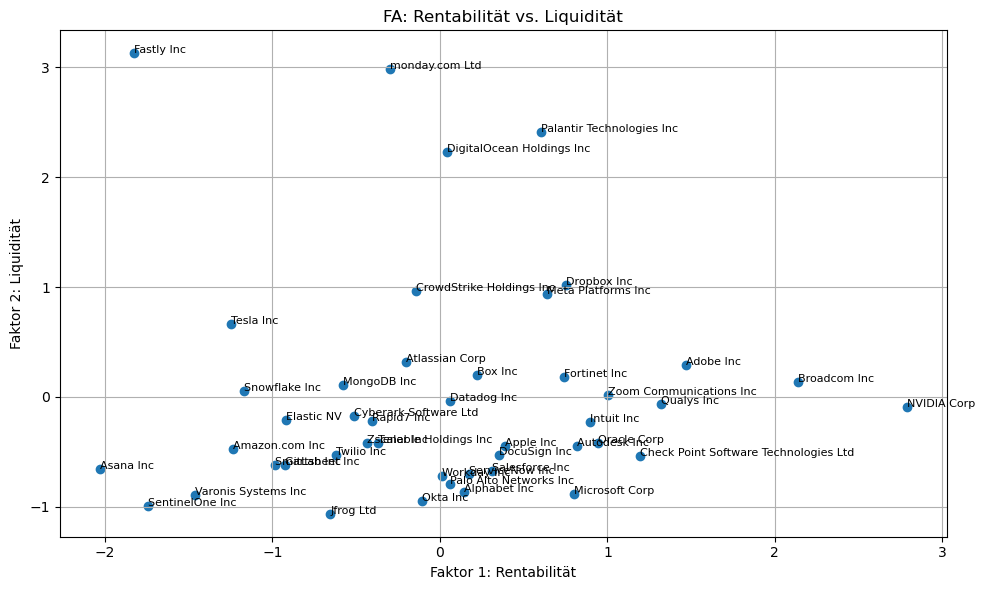

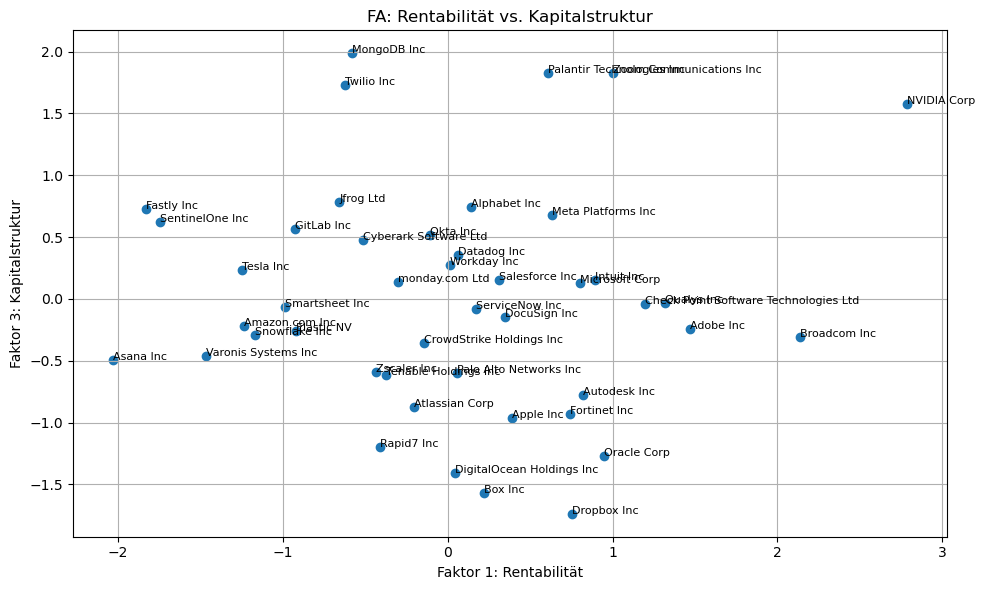

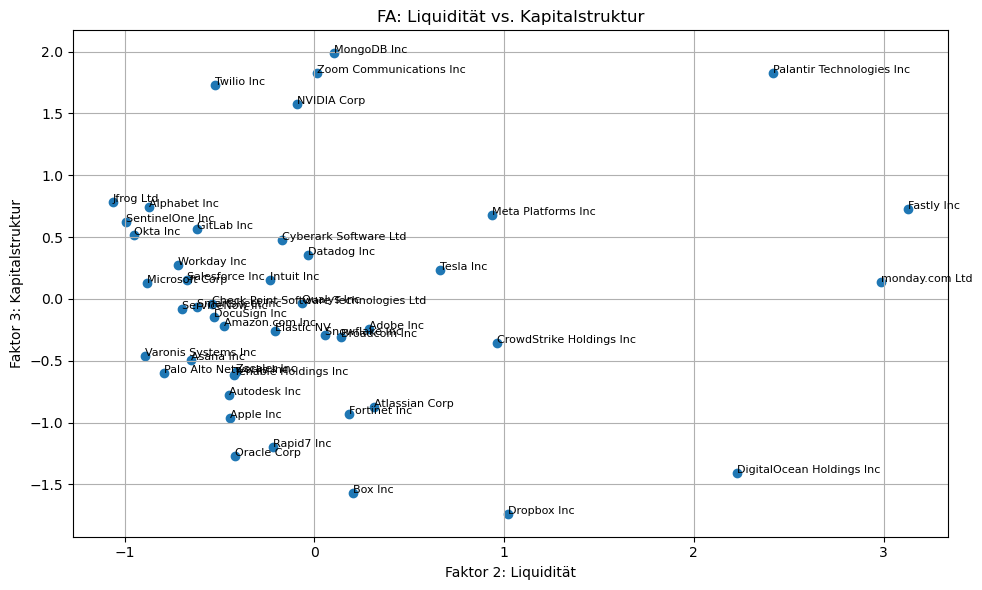

In [18]:

#Plot 1: Rentabilität vs. Liquidität
plt.figure(figsize=(10, 6))
plt.scatter(scores_df["Rentabilität"], scores_df["Liquidität"])
for i in range(scores_df.shape[0]):
    plt.text(scores_df.loc[i, "Rentabilität"], scores_df.loc[i, "Liquidität"], scores_df.loc[i, "Company Name"], fontsize=8)
plt.title("FA: Rentabilität vs. Liquidität")
plt.xlabel("Faktor 1: Rentabilität")
plt.ylabel("Faktor 2: Liquidität")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot 2: Rentabilität vs. Kapitalstruktur
plt.figure(figsize=(10, 6))
plt.scatter(scores_df["Rentabilität"], scores_df["Kapitalstruktur"])
for i in range(scores_df.shape[0]):
    plt.text(scores_df.loc[i, "Rentabilität"], scores_df.loc[i, "Kapitalstruktur"], scores_df.loc[i, "Company Name"], fontsize=8)
plt.title("FA: Rentabilität vs. Kapitalstruktur")
plt.xlabel("Faktor 1: Rentabilität")
plt.ylabel("Faktor 3: Kapitalstruktur")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot 3: Liquidität vs. Kapitalstruktur
plt.figure(figsize=(10, 6))
plt.scatter(scores_df["Liquidität"], scores_df["Kapitalstruktur"])
for i in range(scores_df.shape[0]):
    plt.text(scores_df.loc[i, "Liquidität"], scores_df.loc[i, "Kapitalstruktur"], scores_df.loc[i, "Company Name"], fontsize=8)
plt.title("FA: Liquidität vs. Kapitalstruktur")
plt.xlabel("Faktor 2: Liquidität")
plt.ylabel("Faktor 3: Kapitalstruktur")
plt.grid(True)
plt.tight_layout()
plt.show()


**Clusterung**

In [19]:

#Clusteranzahl
n_clusters = 3

#KMeans anwenden auf die Faktorscores
X_cluster_fa = scores_df[["Rentabilität", "Liquidität", "Kapitalstruktur"]]
kmeans_fa = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
scores_df["Cluster"] = kmeans_fa.fit_predict(X_cluster_fa)

#Clusterzentren speichern
centroids = pd.DataFrame(kmeans_fa.cluster_centers_, columns=X_cluster_fa.columns)
centroids["Cluster"] = centroids.index

#Ergebnisse prüfen
#scores_df.head()
display(scores_df) #Beim präsentieren ausführen


,Rentabilität,Liquidität,Kapitalstruktur,Company Name,Cluster
0,1.471465,0.289940,-0.246349,Adobe Inc,0
1,0.140972,-0.868833,0.740985,Alphabet Inc,1
2,-1.234416,-0.477772,-0.220626,Amazon.com Inc,1
3,0.390245,-0.442008,-0.962801,Apple Inc,0
4,-2.029325,-0.651115,-0.490965,Asana Inc,1
5,-0.205341,0.316717,-0.870192,Atlassian Corp,0
6,0.819870,-0.449095,-0.775185,Autodesk Inc,0
7,0.221764,0.204458,-1.570960,Box Inc,0
8,2.137078,0.139764,-0.304866,Broadcom Inc,0
9,1.194292,-0.537561,-0.037931,Check Point Software Technologies Ltd,0


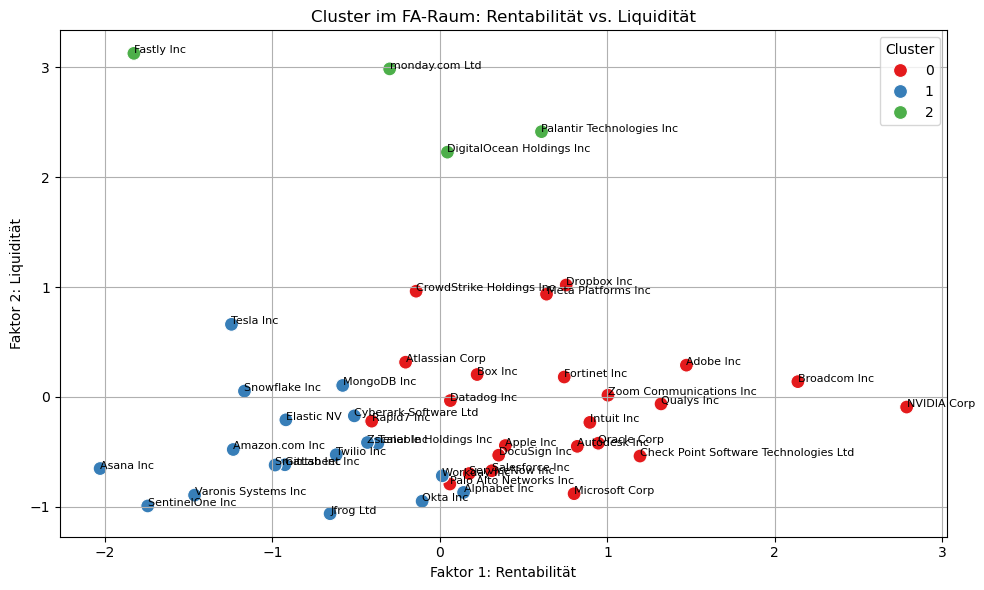

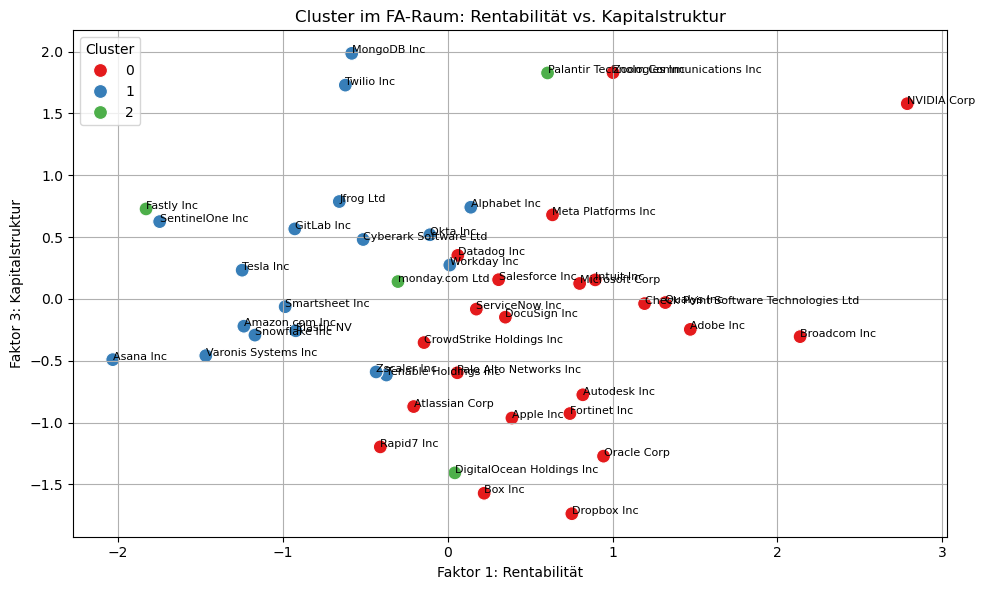

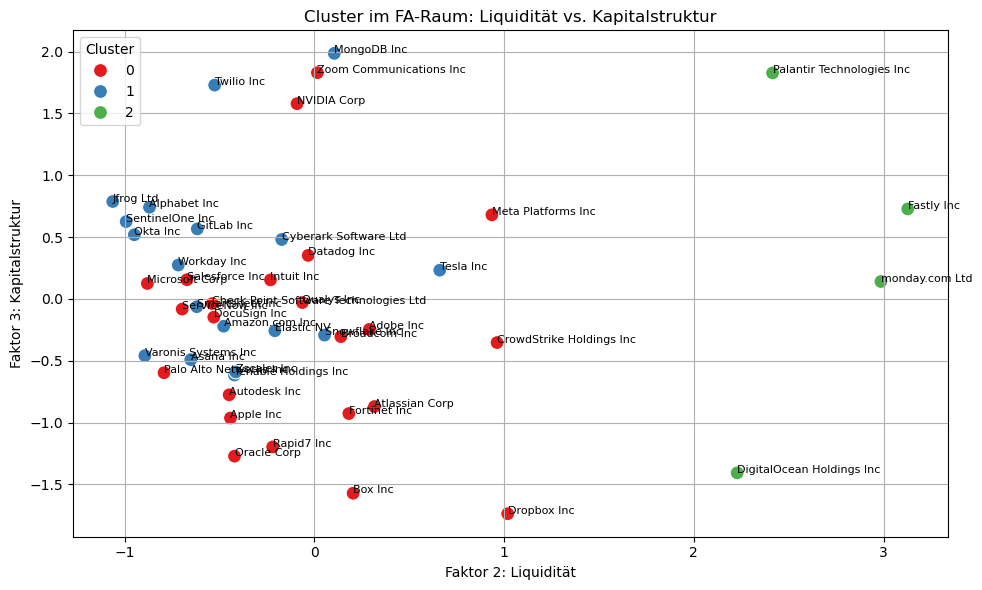

In [20]:

#Plot 1: Rentabilität vs. Liquidität
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scores_df, x="Rentabilität", y="Liquidität", hue="Cluster", palette="Set1", s=100)
for i in range(scores_df.shape[0]):
    plt.text(scores_df.loc[i, "Rentabilität"], scores_df.loc[i, "Liquidität"], scores_df.loc[i, "Company Name"], fontsize=8)
plt.title("Cluster im FA-Raum: Rentabilität vs. Liquidität")
plt.xlabel("Faktor 1: Rentabilität")
plt.ylabel("Faktor 2: Liquidität")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot 2: Rentabilität vs. Kapitalstruktur
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scores_df, x="Rentabilität", y="Kapitalstruktur", hue="Cluster", palette="Set1", s=100)
for i in range(scores_df.shape[0]):
    plt.text(scores_df.loc[i, "Rentabilität"], scores_df.loc[i, "Kapitalstruktur"], scores_df.loc[i, "Company Name"], fontsize=8)
plt.title("Cluster im FA-Raum: Rentabilität vs. Kapitalstruktur")
plt.xlabel("Faktor 1: Rentabilität")
plt.ylabel("Faktor 3: Kapitalstruktur")
plt.grid(True)
plt.tight_layout()
plt.show()

#Plot 3: Liquidität vs. Kapitalstruktur
plt.figure(figsize=(10, 6))
sns.scatterplot(data=scores_df, x="Liquidität", y="Kapitalstruktur", hue="Cluster", palette="Set1", s=100)
for i in range(scores_df.shape[0]):
    plt.text(scores_df.loc[i, "Liquidität"], scores_df.loc[i, "Kapitalstruktur"], scores_df.loc[i, "Company Name"], fontsize=8)
plt.title("Cluster im FA-Raum: Liquidität vs. Kapitalstruktur")
plt.xlabel("Faktor 2: Liquidität")
plt.ylabel("Faktor 3: Kapitalstruktur")
plt.grid(True)
plt.tight_layout()
plt.show()


**Clusterprofil-Matrix**

In [21]:
#Mittelwerte der Faktoren je Cluster berechnen
cluster_profiles = scores_df.groupby("Cluster")[["Rentabilität", "Liquidität", "Kapitalstruktur"]].mean().round(2)

#Ergebnis sortiert anzeigen
cluster_profiles.sort_index()


,Rentabilität,Liquidität,Kapitalstruktur
Cluster,,,
0,0.71,-0.09,-0.27
1,-0.82,-0.49,0.27
2,-0.37,2.69,0.32


**Radarplot**

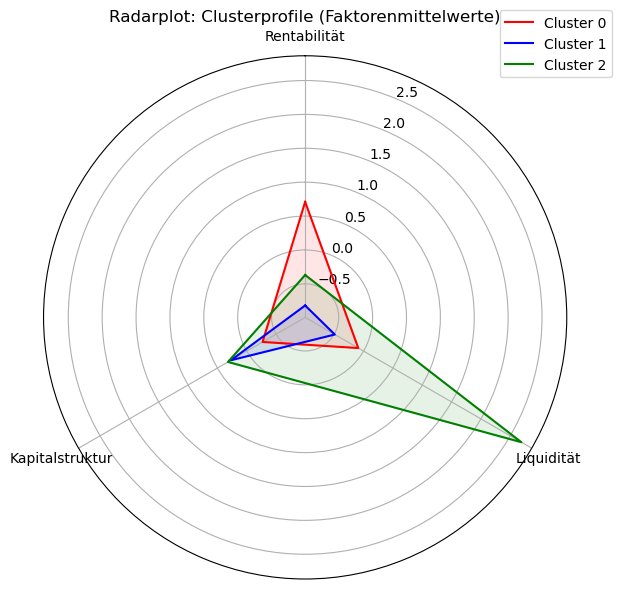

In [22]:


#Clusterprofile manuell definieren (aus deiner Analyse)
cluster_profiles = pd.DataFrame({
    "Rentabilität": [0.71, -0.82, -0.37],
    "Liquidität": [-0.09, -0.49, 2.69],
    "Kapitalstruktur": [-0.27, 0.27, 0.32]
}, index=["Cluster 0", "Cluster 1", "Cluster 2"])

#Vorbereitung für Radarplot
labels = list(cluster_profiles.columns)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # schließen den Kreis

#Plot erstellen
fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

#Farben je Cluster
colors = ["red", "blue", "green"]

#Plot für jeden Cluster
for i, (cluster_name, row) in enumerate(cluster_profiles.iterrows()):
    values = row.tolist() + row.tolist()[:1]
    ax.plot(angles, values, label=cluster_name, color=colors[i])
    ax.fill(angles, values, alpha=0.1, color=colors[i])

#Achsen und Titel
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title("Radarplot: Clusterprofile (Faktorenmittelwerte)")
ax.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()


**Cluster bennenung**

In [23]:
cluster_mapping = {
    0: "Ertragsorientierte",
    1: "Finanziell schwache",
    2: "Liquiditätsorientierte"
}

#Nur wenn 'Cluster' in scores_df existiert:
if "Cluster" in scores_df.columns:
    scores_df['Cluster_Label'] = scores_df['Cluster'].map(cluster_mapping)


**Boxplots**

/var/folders/t8/prdvm2s15t59h3tqywj46zqw0000gn/T/ipykernel_2696/2459487400.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


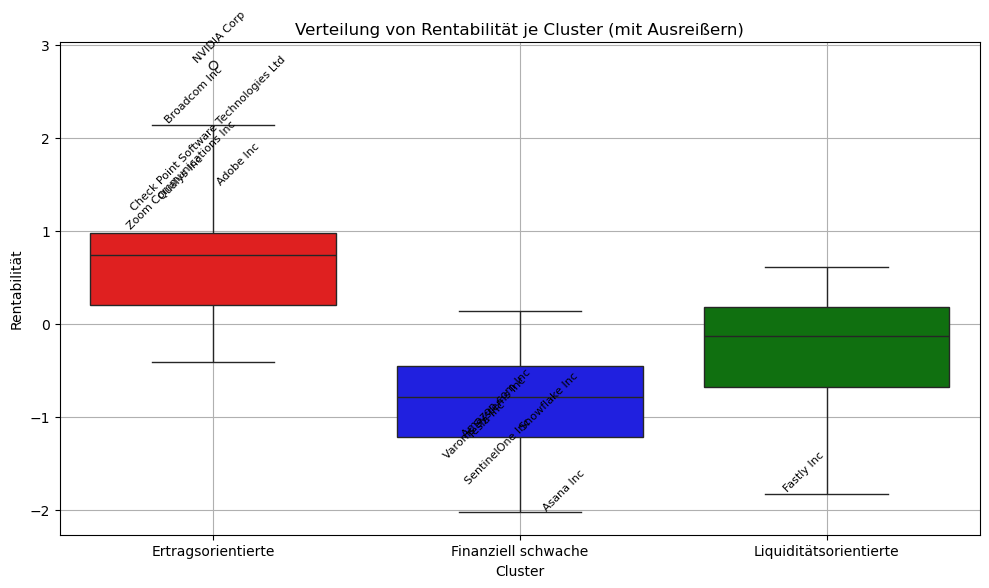

/var/folders/t8/prdvm2s15t59h3tqywj46zqw0000gn/T/ipykernel_2696/2459487400.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


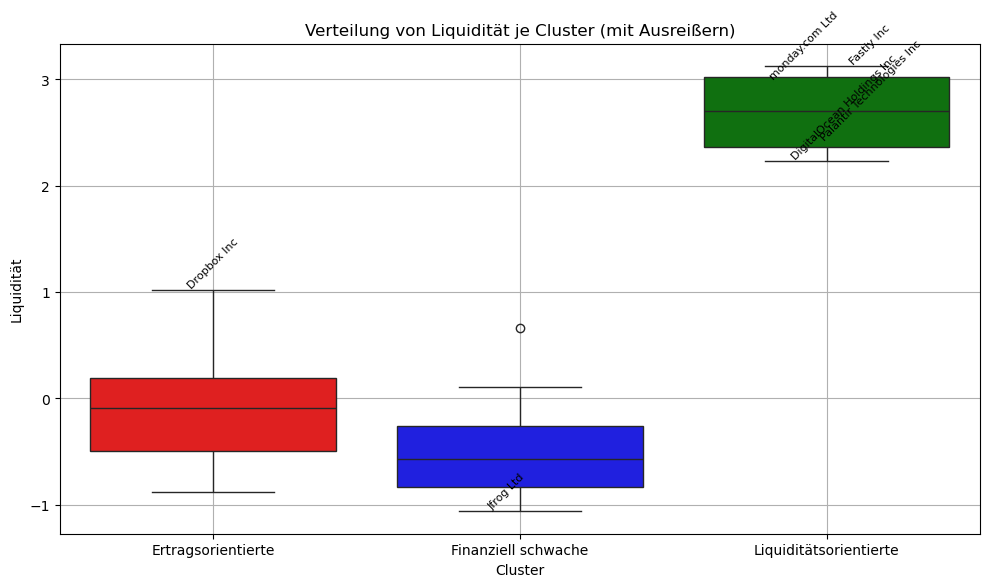

/var/folders/t8/prdvm2s15t59h3tqywj46zqw0000gn/T/ipykernel_2696/2459487400.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(


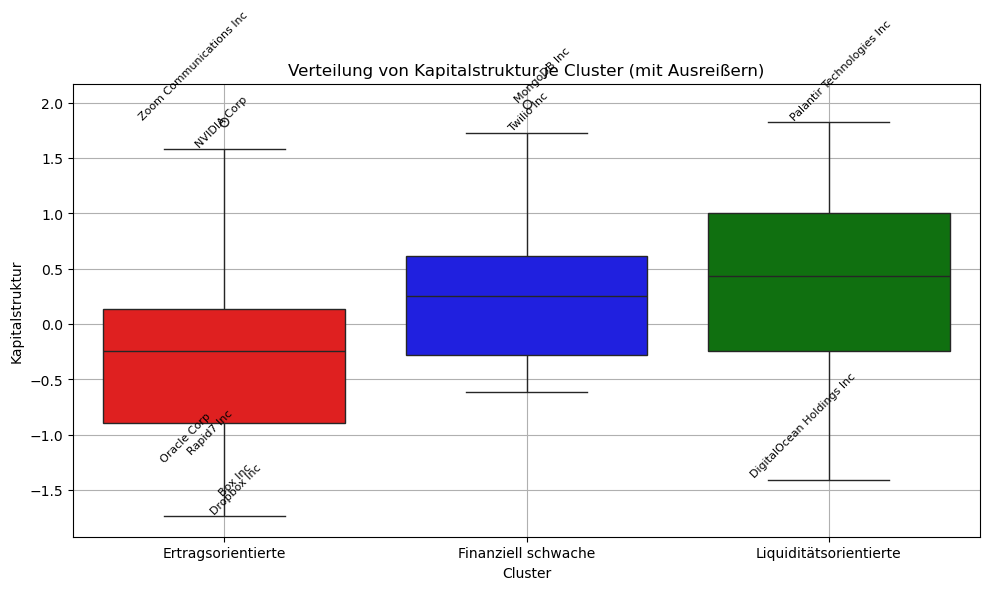

In [24]:

#Manuell definierte Farben passend zum Radarplot
cluster_colors = {
    "Ertragsorientierte": "red",
    "Finanziell schwache": "blue",
    "Liquiditätsorientierte": "green"
}

faktoren = ['Rentabilität', 'Liquidität', 'Kapitalstruktur']

for faktor in faktoren:
    plt.figure(figsize=(10, 6))
    
    #Farbpalette auf Cluster_Label anwenden
    ax = sns.boxplot(
        x='Cluster_Label',
        y=faktor,
        data=scores_df,
        palette=cluster_colors,
        showfliers=True
    )
    
    plt.title(f'Verteilung von {faktor} je Cluster (mit Ausreißern)')
    plt.xlabel('Cluster')
    plt.ylabel(faktor)
    plt.grid(True)
    
    #Ausreißer beschriften
    for i, row in scores_df.iterrows():
        wert = row[faktor]
        if wert > 1.0 or wert < -1.0:
            #Position leicht streuen, damit Labels sich weniger überlappen
            x_pos = list(cluster_colors.keys()).index(row['Cluster_Label']) + np.random.uniform(-0.15, 0.15)
            y_pos = wert
            name = row['Company Name']
            ax.text(x_pos, y_pos, name, fontsize=8, ha='center', va='bottom', rotation=45)

    plt.tight_layout()
    plt.show()



**Matrix übersicht**

In [25]:
cluster_liste = []

for cluster_num in sorted(scores_df['Cluster'].unique()):
    unternehmen = scores_df[scores_df['Cluster'] == cluster_num]['Company Name'].tolist()
    cluster_liste.append({
        'Cluster': f"{cluster_num} – {cluster_mapping[cluster_num]}",
        'Unternehmen': ', '.join(unternehmen)
    })

pd.DataFrame(cluster_liste)



,Cluster,Unternehmen
0,0 – Ertragsorientierte,"Adobe Inc, Apple Inc, Atlassian Corp, Autodesk..."
1,1 – Finanziell schwache,"Alphabet Inc, Amazon.com Inc, Asana Inc, Cyber..."
2,2 – Liquiditätsorientierte,"DigitalOcean Holdings Inc, Fastly Inc, monday...."


In [26]:

for faktor in faktoren:
    groups = [scores_df[scores_df['Cluster'] == k][faktor] for k in scores_df['Cluster'].unique()]
    f, p = f_oneway(*groups)
    print(f"{faktor}: F = {f:.2f}, p = {p:.4f}")


Rentabilität: F = 23.77, p = 0.0000
Liquidität: F = 66.83, p = 0.0000
Kapitalstruktur: F = 2.27, p = 0.1157
